In [80]:
import librosa
import librosa.display
import pyaudio
import queue
from typing import Optional
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
from collections import deque
import IPython.display 
from IPython.display import clear_output
from functools import partial

SAMPLE_RATE = 22050
HOP_LENGTH = 256
CHANNELS = 1
N_FFT = 512
feature_rate = int(SAMPLE_RATE / HOP_LENGTH)

In [81]:
class StreamProcessor:
    def __init__(self, sample_rate, chunk_size, hop_length, n_fft, verbose=True, query_norm=1):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.verbose = verbose
        self.query_norm = query_norm
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.chroma_buffer = queue.Queue()
        self.last_chunk = None
        self.is_mic_open = False
        self.index = 0
    
    def _process_chroma(self, y, time_info=None):
        y = np.concatenate((self.last_chunk, y)) if self.last_chunk is not None else y
        query_chroma_stft = librosa.feature.chroma_stft(  # TODO: center = False 옵션 줘서 해보기
            y=y,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            n_fft=self.n_fft,
            norm=self.query_norm
        )
        # 첫번째 chunk 는 맨 앞의 padding된 stft frame을 버리지 않음
        query_chroma_stft = query_chroma_stft[:, 1:-1] if self.last_chunk is not None else query_chroma_stft[:, :-1]
        current_chunk = {
            "timestamp": time_info if time_info else time.time(),
            "chroma_stft": query_chroma_stft,
        }
        self.chroma_buffer.put(current_chunk)
        self.last_chunk = y[y.shape[0] - self.hop_length:]
        self.index += 1

    def _process_frame(self, data, frame_count, time_info, status_flag):
        if self.verbose:
            print(f'\nprocess_frame index: {self.index}, frame_count: {frame_count}')
            print(f"{self.index}st time_info: {time_info}")

        self.buffer.put(data)

        query_audio = np.frombuffer(data, dtype=np.float32)  # initial y
        self._process_chroma(query_audio, time_info["input_buffer_adc_time"])

        return (data, pyaudio.paContinue)
    
    def mock_stream(self, mock_file=None):
        filename = mock_file or "../resources/audio/target/presto_musescore/Haydn_Hob._XVI34_1._Presto.wav"
        stream = librosa.stream(
            filename, 
            block_length=1, 
            frame_length=self.chunk_size,
            hop_length=self.hop_length
        )
        for y_block in stream:
            self._process_chroma(y_block)


    def run(self, fake=False, mock_file=None):
        if fake:
            print(f"* [Mocking] Loading existing audio file({mock_file})....")
            self.mock_stream(mock_file)
            print("* [Mocking] Done.")
        else:
            self.audio_interface = pyaudio.PyAudio()
            self.audio_stream = self.audio_interface.open(
                format=self.format,
                channels=self.channels,
                rate=self.sample_rate,
                input=True,
                frames_per_buffer=self.chunk_size,
                stream_callback=self._process_frame,
            )
            self.is_mic_open = True
            self.audio_stream.start_stream()
            self.start_time = self.audio_stream.get_time()
            print("* Recording in progress....")

    def stop(self):
        if self.is_mic_open:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.is_mic_open = False
            self.audio_interface.terminate()
            print("Recording Stopped.")
    
    def is_open(self):
        return self.is_mic_open

In [87]:
MAX_LEN = int(1e4)
HOP_LENGTH = 256

from enum import IntEnum
import scipy


class Direction(IntEnum):
    REF = 1
    QUERY = 2
    BOTH = REF | QUERY

class OnlineTimeWarping:
    def __init__(
        self,
        sp: StreamProcessor,
        ref_audio_path,
        window_size,
        max_run_count=30,
        hop_length=HOP_LENGTH,
        verbose=True,
    ):
        self.sp = sp
        self.ref_audio_file = ref_audio_path
        self.window_size = window_size
        self.max_run_count = max_run_count
        self.hop_length = hop_length
        self.frame_per_seg = int(sp.chunk_size / hop_length)
        self.verbose = verbose
        self.ref_pointer = 0
        self.time_length = 0
        self.distance = 0
        self.run_count = 0
        self.previous_direction = None
        self.current_query_stft = None  # (12, n)
        self.query_stft = np.zeros((12, MAX_LEN))  # (12, N) stft of total query
        self.query_audio = np.array([])
        self.index1s = np.array([])
        self.index2s = np.array([])
        self.warping_path = []
        self.cost_matrix = None
        self.dist_matrix = None
        self.acc_dist_matrix = None
        self.acc_len_matrix = None
        self.candidate = None
        self.candi_history = []
        self.iteration = 0
        self.acc_direction = None
        self.cost_matrix_offset = [0, 0]  # (ref, query)
        self.query_pointer = 0
        self.w = self.frame_per_seg * self.window_size

        self.initialize_ref_audio(ref_audio_path)

    def offset(self):
        offset_x = max(self.ref_pointer - self.w, 0)
        offset_y = max(self.query_pointer - self.w, 0)
        return np.array([offset_x, offset_y])

    def local_to_global_index(self, coord):
        return coord + self.offset()

    def global_to_local_index(self, coord):
        return coord - self.offset()

    def initialize_ref_audio(self, audio_path):
        audio_y, sr = librosa.load(audio_path)
        self.ref_audio = audio_y
        ref_stft = librosa.feature.chroma_stft(
            y=audio_y, sr=sr, hop_length=HOP_LENGTH, n_fft=N_FFT, norm=1
        )
        ref_len = ref_stft.shape[1]
        truncated_len = (
            (ref_len - 1) // self.frame_per_seg
        ) * self.frame_per_seg  # initialize_ref_audio 에서 ref_stft 길이가 frame_per_seg (4) 로 나눠지게 마지막을 버림
        self.ref_stft = ref_stft[:, :truncated_len]

        self.global_cost_matrix = np.zeros(
            (self.ref_stft.shape[1] * 2, self.ref_stft.shape[1] * 2)
        )

    def init_dist_matrix(self):
        print("init")
        ref_stft_seg = self.ref_stft[:, : self.ref_pointer]  # [F, M]
        query_stft_seg = self.query_stft[:, : self.query_pointer]  # [F, N]
        dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)

        if self.verbose:
            print(
                f"ref_stft_seg: {ref_stft_seg.shape}, query_stft_seg: {query_stft_seg.shape}, dist: {dist.shape}, dist_matrix shape: {self.dist_matrix.shape}"
            )
        w = self.window_size * self.frame_per_seg
        self.dist_matrix[w - dist.shape[0] :, w - dist.shape[1] :] = dist

    def update_dist_matrix(self, direction: Direction):
        if self.verbose:
            print(f"update_path_cost with direction: {direction.name}")
        x = self.ref_pointer
        y = self.query_pointer
        w = self.window_size * self.frame_per_seg

        ref_stft_seg = self.ref_stft[:, max(x - w, 0) : x]  # [F, M]
        query_stft_seg = self.query_stft[:, max(y - w, 0) : y]  # [F, N]
        dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)
        if self.verbose:
            print(
                f"current pointer: {(x, y)}, ref shape: {ref_stft_seg.shape} query shape: {query_stft_seg.shape}, dist shape: {dist.shape}, dist_matrix shape: {self.dist_matrix.shape}"
            )

        self.dist_matrix[
            w - dist.shape[0] :, w - dist.shape[1] :
        ] = dist  # dist_matrix 끝 점에 맞춰서 항상 업데이트 되도록 함.

    def init_matrix(self):
        x = self.ref_pointer
        y = self.query_pointer
        w = self.w
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)
        new_acc = np.zeros((wx, wy))
        new_len_acc = np.zeros((wx, wy))
        x_seg = self.ref_stft[:, x - wx : x].T  # [wx, 12]
        y_seg = self.query_stft[:, y - d : y].T  # [d, 12]
        dist = scipy.spatial.distance.cdist(x_seg, y_seg)  # [wx, d``]

        for i in range(wx):
            for j in range(d):
                local_dist = dist[i, j]
                update_x0 = 0
                update_y0 = wy - d
                if i == 0 and j == 0:
                    new_acc[i,j] = local_dist
                elif i == 0:
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i, update_y0 - 1]
                    new_len_acc[i, update_y0 + j] = 1 + new_len_acc[i, update_y0 - 1]
                elif j == 0 :
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i-1, update_y0]
                    new_len_acc[i, update_y0 + j] = local_dist + new_len_acc[i-1, update_y0]
                else:
                    compares = [
                        new_acc[i - 1, update_y0 + j],
                        new_acc[i, update_y0 + j - 1],
                        new_acc[i - 1, update_y0 + j - 1],
                    ]
                    len_compares = [
                        new_len_acc[i - 1, update_y0 + j],
                        new_len_acc[i, update_y0 + j - 1],
                        new_len_acc[i - 1, update_y0 + j - 1],
                    ]
                    local_direction = np.argmin(compares)
                    new_acc[i, update_y0 + j] = local_dist + compares[local_direction]
                    new_len_acc[i, update_y0 + j] = 1 + len_compares[local_direction]
        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc
        self.select_candidate()

    def update_accumulate_matrix(self, direction):
        # local cost matrix
        x = self.ref_pointer
        y = self.query_pointer
        w = self.w
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)
        new_acc = np.zeros((wx, wy))
        new_len_acc = np.zeros((wx, wy))

        if direction == Direction.REF:
            new_acc[:-d, :] = self.acc_dist_matrix[d:]
            new_len_acc[:-d, :] = self.acc_len_matrix[d:]
            x_seg = self.ref_stft[:, x - d : x].T  # [d, 12]
            y_seg = self.query_stft[:, y - wy : y].T  # [wy, 12]
            dist = scipy.spatial.distance.cdist(x_seg, y_seg)  # [d, wy]

            for i in range(d):
                for j in range(wy):
                    local_dist = dist[i, j]
                    update_x0 = wx - d
                    update_y0 = 0
                    if j == 0:
                        new_acc[update_x0 + i, j] = local_dist + new_acc[update_x0 + i - 1, j]
                        new_len_acc[update_x0 + i, j] = (
                            new_len_acc[update_x0 + i - 1, j] + 1
                        )
                    else:
                        compares = [
                            new_acc[update_x0 + i - 1, j],
                            new_acc[update_x0 + i, j - 1],
                            new_acc[update_x0 + i - 1, j - 1],
                        ]
                        len_compares = [
                            new_len_acc[update_x0 + i - 1, j],
                            new_len_acc[update_x0 + i, j - 1],
                            new_len_acc[update_x0 + i - 1, j - 1],
                        ]
                        local_direction = np.argmin(compares)
                        new_acc[update_x0 + i, j] = local_dist + compares[local_direction]
                        new_len_acc[update_x0 + i, j] = (
                            1 + len_compares[local_direction]
                        )

        elif direction == Direction.QUERY:
            overlap_y = wy - d
            new_acc[:, :-d] = self.acc_dist_matrix[:, -overlap_y:]
            new_len_acc[:, :-d] = self.acc_len_matrix[:, -overlap_y:]
            x_seg = self.ref_stft[:, x - wx : x].T  # [wx, 12]
            y_seg = self.query_stft[:, y - d : y].T  # [d, 12]
            dist = scipy.spatial.distance.cdist(x_seg, y_seg)  # [wx, d``]

            for i in range(wx):
                for j in range(d):
                    local_dist = dist[i, j]
                    update_x0 = 0
                    update_y0 = wy - d
                    if i == 0:
                        new_acc[i, update_y0 + j] = local_dist + new_acc[i, update_y0 - 1]
                        new_len_acc[i, update_y0 + j] = (
                            1 + new_len_acc[i, update_y0 - 1]
                        )
                    else:
                        compares = [
                            new_acc[i - 1, update_y0 + j],
                            new_acc[i, update_y0 + j - 1],
                            new_acc[i - 1, update_y0 + j - 1],
                        ]
                        len_compares = [
                            new_len_acc[i - 1, update_y0 + j],
                            new_len_acc[i, update_y0 + j - 1],
                            new_len_acc[i - 1, update_y0 + j - 1],
                        ]
                        local_direction = np.argmin(compares)
                        new_acc[i, update_y0 + j] = local_dist + compares[local_direction]
                        new_len_acc[i, update_y0 + j] = (
                            1 + len_compares[local_direction]
                        )
        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc
        """
        cm_x, cm_y = min(w + 1, x + 1), min(w + 1, y + 1)  # cost_matrix 의 shape
        table = np.zeros((cm_x, cm_y))

        # Compute left column separately, i.e. j=0.
        table[1:, 0] = np.inf

        # Compute top row separately, i.e. i=0.
        table[0, 1:] = np.inf

        for i in range(1, cm_x):
            for j in range(1, cm_y):
                d = scipy.spatial.distance.euclidean(
                    ref_stft_seg[i - 1], query_stft_seg[j - 1]
                )
                table[i, j] = d + min(
                    table[i - 1, j], table[i, j - 1], table[i - 1, j - 1]
                )

        self.cost_matrix = table
        """

    def calculate_warping_path(self, start, end):
        """calculate each warping path from start to end point and return distance"""
        wp = None
        distance = None
        return wp, distance

    def update_warping_path(self):
        table = self.cost_matrix
        i = self.cost_matrix.shape[0] - 1
        j = (
            self.cost_matrix.shape[1] - 1
        )  # start = (i, j), end = (ref_until, query_until)

        ref_until = 0
        query_until = 0

        offset = self.offset()
        if offset[0] < 0 or offset[1] < 0:
            ref_until = max(i - self.ref_pointer, 0)
            query_until = max(j - self.query_pointer, 0)

        path = [(i, j)]
        while i > ref_until or j > query_until:
            minval = np.inf
            if table[i - 1, j] < minval:
                minval = table[i - 1, j]
                step = (i - 1, j)
            if table[i][j - 1] < minval:
                minval = table[i, j - 1]
                step = (i, j - 1)
            if table[i - 1][j - 1] < minval:
                minval = table[i - 1, j - 1]
                step = (i - 1, j - 1)
            path.insert(0, step)
            i, j = step
        path += offset
        self.warping_path.extend(path)

    def update_path_cost(self, direction):
        self.update_accumulate_matrix(direction)
        self.select_candidate()
        # self.update_warping_path()

    def select_candidate(self):
        norm_x_edge = self.acc_dist_matrix[-1, :] / self.acc_len_matrix[-1, :]
        norm_y_edge = self.acc_dist_matrix[:, -1] / self.acc_len_matrix[:, -1]
        cat = np.concatenate((norm_x_edge, norm_y_edge))
        min_idx = np.argmin(cat)
        offset = self.offset()
        if min_idx <= len(norm_x_edge):
            self.candidate = np.array([self.ref_pointer - offset[0], min_idx])
        else:
            self.candidate = np.array(
                [min_idx - len(norm_x_edge), self.query_pointer - offset[1]]
            )

    def save_history(self):
        offset = self.offset()
        self.candi_history.append(offset + self.candidate)

    def select_next_direction(self):
        if self.run_count > self.max_run_count:
            if self.previous_direction == Direction.REF:
                next_direction = Direction.QUERY
            else:
                next_direction = Direction.REF

        offset = self.offset()
        x0 = offset[0]
        y0 = offset[1]
        if self.candidate[0] == self.ref_pointer - x0:
            # ref direction
            next_direction = Direction.REF
        else:
            assert self.candidate[1] == self.query_pointer - y0
            next_direction = Direction.QUERY
        self.save_history()

        """
        last_ref_path, last_query_path = self.warping_path[-1]
        print(
            f"self.ref_pointer: {self.ref_pointer}, last_ref_path: {last_ref_path} / self.query_pointer: {self.query_pointer} last_query_path: {last_query_path}, "
        )
        if last_ref_path == self.ref_pointer and last_query_path == self.query_pointer:
            next_direction = Direction.BOTH
        elif last_ref_path < last_query_path:
            next_direction = Direction.QUERY
        elif last_ref_path == last_query_path:
            next_direction = Direction.BOTH
        else:
            next_direction = direction.ref
        print(f"next_direction: {next_direction.name}")
        """
        return next_direction

        # return Direction.BOTH

    def get_new_input(self):
        #  get only one input
        """
        qsize = self.sp.chroma_buffer.qsize()
        if qsize <= 1:
            query_chroma_stft = self.sp.chroma_buffer.get()['chroma_stft']
        else:
            print(f"qsize more than 1!")
            # query_chroma_stft = np.zeros(())
            chroma_stfts = [self.sp.chroma_buffer.get()['chroma_stft'] for _ in range(qsize)]  # (12, self.frame_per_seg) * qsize
            query_chroma_stft = np.hstack(chroma_stfts)
        """
        query_chroma_stft = self.sp.chroma_buffer.get()["chroma_stft"]
        self.current_query_stft = query_chroma_stft
        q_length = self.current_query_stft.shape[1]
        self.query_stft[
            :, self.query_pointer : self.query_pointer + q_length
        ] = query_chroma_stft
        self.query_pointer += q_length
        if self.verbose:
            print(f"updated q_index: {self.query_pointer}, q_length: {q_length}")
    
    def _check_run_time(self, start_time, duration):
        return time.time() - start_time < duration

    def run(self, fig, h, hfig, duration=None, fake=False):
        self.sp.run(fake)  # mic ON
        start_time = time.time()

        self.ref_pointer += self.window_size * self.frame_per_seg
        self.get_new_input()
        self.init_matrix()

        run_condition = partial(self._check_run_time, start_time, duration) if duration is not None else self.sp.is_open
        is_still_following = self.ref_pointer <= (self.ref_stft.shape[1] - self.frame_per_seg)
        while run_condition() and is_still_following:
            if self.verbose:
                print(f"\niteration: {self.iteration}")
            direction = self.select_next_direction()

            if direction is Direction.QUERY:
                self.get_new_input()
                self.update_path_cost(direction)

            elif direction is Direction.REF:
                self.ref_pointer += self.frame_per_seg
                self.update_path_cost(direction)

            if direction == self.previous_direction:
                self.run_count += 1
            else:
                self.run_count = 1

            # if direction is not Direction.BOTH:
            self.previous_direction = direction
            self.iteration += 1

            if duration is None:
                duration = int(librosa.get_duration(filename=self.ref_audio_file)) + 1
            h.set_data(self.query_stft[:, :int(SAMPLE_RATE/HOP_LENGTH) * duration])
            #             clear_output(wait=True)
            hfig.update(fig)

        end_time = time.time()
        print(f"duration: {end_time - start_time}")
        self.sp.stop()


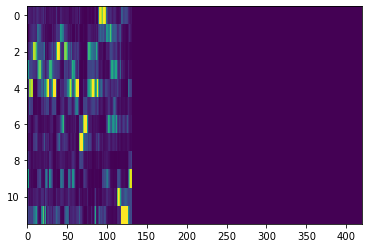

* Recording in progress....
error! : index 0 is out of bounds for axis 0 with size 0, <class 'IndexError'>
Recording Stopped.


  File "/var/folders/wf/m9s1kcjn5m3cm0k81x5_k_hc0000gn/T/ipykernel_10058/2578250811.py", line 20, in <cell line: 19>
    odtw.run(fig, h, hfig)
  File "/var/folders/wf/m9s1kcjn5m3cm0k81x5_k_hc0000gn/T/ipykernel_10058/3048447146.py", line 404, in run
    self.update_path_cost(direction)
  File "/var/folders/wf/m9s1kcjn5m3cm0k81x5_k_hc0000gn/T/ipykernel_10058/3048447146.py", line 300, in update_path_cost
    self.update_accumulate_matrix(direction)
  File "/var/folders/wf/m9s1kcjn5m3cm0k81x5_k_hc0000gn/T/ipykernel_10058/3048447146.py", line 178, in update_accumulate_matrix
    local_dist = dist[i, j]


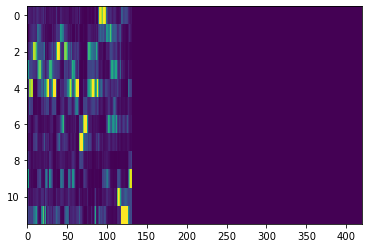

In [88]:
# ref_audio_path = "../resources/audio/target/Haydn_Hob.XVI34_1-1.wav"
ref_audio_path = "../resources/audio/target/Pollini_Maurizio.wav"
SAMPLE_RATE = 22050
CHUNK_SIZE = 4096
N_FFT = 2048
HOP_LENGTH = 1024
duration = int(librosa.get_duration(filename=ref_audio_path)) + 1
# duration = 1

import traceback

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE, hop_length=HOP_LENGTH, n_fft=N_FFT, verbose=False)
odtw = OnlineTimeWarping(sp, ref_audio_path, window_size=int(SAMPLE_RATE/HOP_LENGTH), verbose=False, hop_length=HOP_LENGTH, max_run_count=30)
fig = plt.figure()
ax = fig.gca()
hfig = display(fig, display_id=True)
h = ax.imshow(np.zeros((12, int(SAMPLE_RATE/HOP_LENGTH) * duration)), aspect='auto', vmin=0, vmax=0.5, interpolation='nearest')

try:
    odtw.run(fig, h, hfig)
    
except Exception as e:
    print(f"error! : {str(e)}, {type(e)}")
    traceback.print_tb(e.__traceback__)
    sp.stop()
    pass

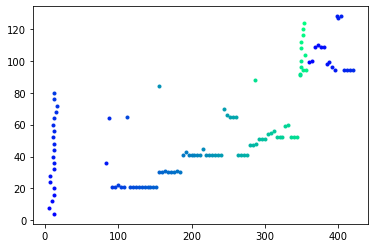

In [90]:
x,y  = zip(*odtw.candi_history)

from matplotlib import cm
cmap = cm.get_cmap('winter', 100)
for n in range(len(x)):
    plt.plot(x[n], y[n], '.', color=cmap(n%100))

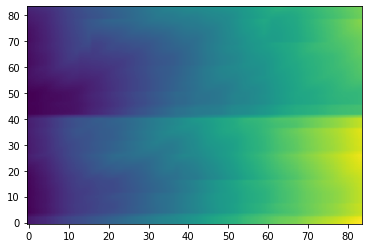

In [91]:
plt.imshow(odtw.acc_dist_matrix.T, aspect='auto', origin='lower')

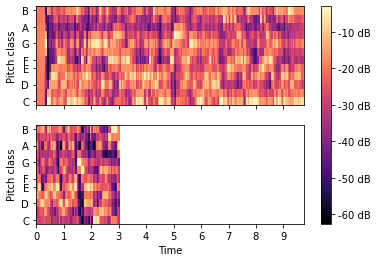

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D1 = librosa.amplitude_to_db(np.abs(odtw.ref_stft[:, :odtw.ref_pointer]))
img = librosa.display.specshow(D1, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].label_outer()

D2 = librosa.amplitude_to_db(np.abs(odtw.query_stft[:, :odtw.query_pointer]))
img = librosa.display.specshow(D2, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

# plt.imshow(odtw.query_stft[:, :odtw.q_index], aspect='auto')

In [90]:
np.mean(np.abs(odtw.ref_stft[:, :odtw.ref_pointer]))

143.78177

In [91]:
np.mean(np.abs(odtw.query_stft[:, :odtw.query_pointer]))

0.03926360994463115

In [ ]:
np.mean(np.abs(odtw.ref_stft))

143.78177

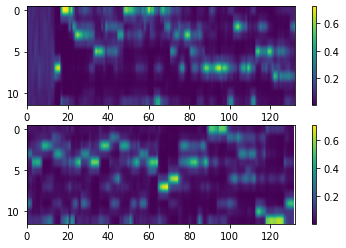

In [93]:
# max_step = np.max((odtw.ref_pointer, odtw.query_pointer))
max_step = np.min((odtw.ref_pointer, odtw.query_pointer))
plt.subplot(211)
plt.imshow(odtw.ref_stft[:, :odtw.ref_pointer], aspect='auto')
plt.xlim(0,max_step)
plt.colorbar()
plt.subplot(212)
plt.imshow(odtw.query_stft[:, :odtw.query_pointer], aspect='auto')
plt.xlim(0,max_step)
plt.colorbar()

odtw.query_pointer: 132


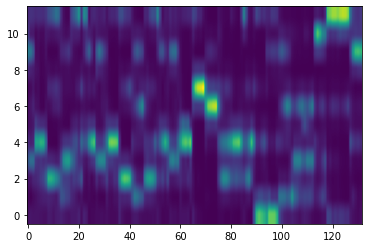

In [94]:
print(f"odtw.query_pointer: {odtw.query_pointer}")
plt.imshow(odtw.query_stft[:, :odtw.query_pointer], aspect='auto', origin='lower')

In [154]:
odtw.sp.chroma_buffer.qsize()

4

i, j: (420, 132)
table shape: (421, 133)


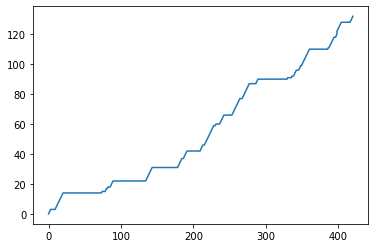

In [96]:
def dtw_table(x, y):
    distance = scipy.spatial.distance.euclidean
    nx = len(x)
    ny = len(y)
    table = np.zeros((nx+1, ny+1))
    
    # Compute left column separately, i.e. j=0.
    table[1:, 0] = np.inf
        
    # Compute top row separately, i.e. i=0.
    table[0, 1:] = np.inf
        
    # Fill in the rest.
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            d = distance(x[i-1], y[j-1])
            table[i, j] = d + min(table[i-1, j], table[i, j-1], table[i-1, j-1])
    return table

def dtw(x, y, table):
    i = len(x)
    j = len(y)
    path = [(i, j)]
    print(f"i, j: {i, j}")
    print(f"table shape: {table.shape}")
    while i > 0 or j > 0:
        minval = np.inf
        if table[i-1, j] < minval:
            minval = table[i-1, j]
            step = (i-1, j)
        if table[i][j-1] < minval:
            minval = table[i, j-1]
            step = (i, j-1)
        if table[i-1][j-1] < minval:
            minval = table[i-1, j-1]
            step = (i-1, j-1)
        path.insert(0, step)
        i, j = step
    return path

D = dtw_table(odtw.ref_stft[:, :odtw.ref_pointer].T, odtw.query_stft[:, :odtw.query_pointer].T)
path = dtw(odtw.ref_stft[:, :odtw.ref_pointer].T, odtw.query_stft[:, :odtw.query_pointer].T, D)
plt.plot([i for i, j in path], [j for i, j in path])
plt.show()

In [42]:
import pandas as pd

df = pd.DataFrame(D)
df

,0,1,2,3,4,5,6,7,8
0,0.0,inf,inf,inf,inf,inf,inf,inf,inf
1,inf,0.763906,1.525038,2.598152,3.840440,5.297594,7.345867,9.224375,10.875354
2,inf,2.121968,2.099195,3.310744,4.294718,5.297478,6.947687,8.461795,9.862259
3,inf,3.545559,3.477354,3.953391,5.085559,5.789965,6.998254,8.509391,9.911880
4,inf,4.876066,4.774355,5.236643,5.660564,6.559390,7.549737,8.611463,9.995776
5,inf,6.143378,5.991092,6.460971,6.866360,7.080249,8.303221,9.146767,10.074781
6,inf,7.382236,7.169940,7.644932,8.054950,8.255330,8.816617,9.893630,10.599508
7,inf,8.523927,8.284030,8.734660,9.166785,9.415319,10.037074,10.451572,11.378587
8,inf,9.769278,9.511612,9.961866,10.370874,10.600032,11.180837,11.647706,11.927988
9,inf,10.991425,10.718729,11.164001,11.585034,11.809975,12.391561,12.814644,13.142762


In [98]:
def online_dtw():
    table = odtw.cost_matrix
    i = odtw.cost_matrix.shape[0] - 1
    j = odtw.cost_matrix.shape[1] - 1
    
    ref_until = 0
    query_until = 0
    
    offset = odtw.offset()
    if offset[0] < 0 or offset[1] < 0:
        ref_until = max(i - odtw.ref_pointer, 0)
        query_until = max(j - odtw.q_index, 0)
        
    path = [(i, j)]
    print(f"i: {i}, j: {j}, offset: {offset}, ref_until: {ref_until}, query_until: {query_until}")
    while i > ref_until or j > query_until:
        minval = np.inf
        if table[i - 1, j] < minval:
            minval = table[i - 1, j]
            step = (i - 1, j)
        if table[i][j - 1] < minval:
            minval = table[i, j - 1]
            step = (i, j - 1)
        if table[i - 1][j - 1] < minval:
            minval = table[i - 1, j - 1]
            step = (i - 1, j - 1)
        path.insert(0, step)
        i, j = step
    return path

'''
table = self.cost_matrix
i = self.dist_matrix.shape[0]
j = self.dist_matrix.shape[1]

ref_until = 0
query_until = 0

offset = self.offset()
if offset[0] < 0 or offset[1] < 0:
    ref_until = max(i - self.ref_pointer, 0)
    query_until = max(j - self.q_index, 0)
path = [(i, j)]
while i > ref_until and j > query_until:
    minval = np.inf
    if table[i-1, j] < minval:
        minval = table[i-1, j]
        step = (i-1, j)
    if table[i][j-1] < minval:
        minval = table[i, j-1]
        step = (i, j-1)
    if table[i-1][j-1] < minval:
        minval = table[i-1, j-1]
        step = (i-1, j-1)
    path.insert(0, step)
    i, j = step
path += self.offset()
self.warping_path = path
'''
# x = odtw.ref_stft[:, :odtw.ref_pointer].T
# y =  odtw.query_stft[:, :odtw.q_index].T
# D = dtw_table(x, y)
path = online_dtw()
plt.plot([i for i, j in path], [j for i, j in path])
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'